In [2]:
import numpy as np
import pandas as pd
import yaml
import torch
from copy import deepcopy
import matplotlib.pyplot as plt
from celldreamer.eval.eval_utils import normalize_and_compute_metrics
import scipy.sparse as sp
from celldreamer.eval.evaluate import compute_prdc


from torch import nn
import scanpy as sc    

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.fm.denoising_model import SimpleMLPTimeStep
from celldreamer.models.fm.fm import FM
from celldreamer.eval.optimal_transport import wasserstein
import random
from celldreamer.models.base.encoder_model import EncoderModel
from celldreamer.models.base.utils import unsqueeze_right

device  = "cuda" if torch.cuda.is_available() else "cpu"

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


**Util function**

## Step 1: Initialize data

In [3]:
dataset_config = {'dataset_path': '../../datasets/processed/dentategyrus.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['clusters'],
                    'conditioning_covariate': 'clusters',
                    'subsample_frac': 1,
                    'encoder_type': 'learnt_encoder',
                    'target_max': 1,
                    'target_min': -1,
                    'one_hot_encode_features': False,
                    'split_rates': [0.90, 0.05, 0.05],
                    'cov_embedding_dimensions': 256}

data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                                layer_key=dataset_config["layer_key"],
                                covariate_keys=dataset_config["covariate_keys"],
                                subsample_frac=dataset_config["subsample_frac"], 
                                encoder_type=dataset_config["encoder_type"],
                                target_max=dataset_config["target_max"], 
                                target_min=dataset_config["target_min"])

dataloader = torch.utils.data.DataLoader(dataset,
                                            batch_size=256,
                                            shuffle=True,
                                            num_workers=4, 
                                            drop_last=True)

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}
scaler = dataset.get_scaler()
n_cat = len(dataset.id2cov["clusters"])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


learnt_encoder


## Step 2: Initialize encoder

In [4]:
encoder_config = {
    "x0_from_x_kwargs": {
        "dims": [512, 512],
        "batch_norm": True,
        "dropout": False,
        "dropout_p": 0.0
    },
    "learning_rate": 0.001,
    "weight_decay": 0.00001,
    "covariate_specific_theta": False
}

state_dict_path = "/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/train_encoder_dentategyrus/2d149a86-99da-46cd-804e-58d219c22b5a/checkpoints/last.ckpt"

In [5]:
encoder_model = EncoderModel(in_dim=in_dim,
                              scaler=scaler, 
                              n_cat=n_cat,
                              conditioning_covariate=dataset_config["conditioning_covariate"], 
                              encoder_type=dataset_config["encoder_type"],
                              **encoder_config)

encoder_model.load_state_dict(torch.load(state_dict_path)["state_dict"])

encoder_model.eval()

EncoderModel(
  (x0_from_x): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=2000, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (1): Sequential(
        (0): Linear(in_features=512, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (2): Linear(in_features=512, out_features=2000, bias=True)
    )
  )
)

## Initialize FM model

In [6]:
generative_model_config = {'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'antithetic_time_sampling': True,
                            'sigma': 0.0001
                        }

In [7]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/fm_resnet_encoder_dentate/697d5127-a4dd-4337-96b9-e56a112ed5b0/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]
denoising_model

MLPTimeStep(
  (time_embedder): Sequential(
    (0): Linear(in_features=256, out_features=1024, bias=True)
    (1): SiLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (size_factor_embedder): Sequential(
    (0): Linear(in_features=256, out_features=1024, bias=True)
    (1): SiLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (condition_embedder): Sequential(
    (0): Linear(in_features=256, out_features=1024, bias=True)
    (1): SiLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (net_in): Linear(in_features=2000, out_features=512, bias=True)
  (blocks): ModuleList(
    (0-1): 2 x ResnetBlock(
      (net1): Sequential(
        (0): SiLU()
        (1): Linear(in_features=512, out_features=512, bias=True)
      )
      (cond_proj): Sequential(
        (0): SiLU()
        (1): Linear(in_features=1024, out_features=512, bias=True)
      )
      (net2): Sequential(
        (0): SiLU()
        (1): Linear(in_features

In [8]:
print(ckpt["hyper_parameters"]["feature_embeddings"]["clusters"].embeddings.weight)
feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Parameter containing:
tensor([[-0.0350,  2.5809,  0.1886,  ..., -0.7113,  2.0836,  1.1324],
        [-1.0231,  1.3473,  0.3863,  ...,  0.2668,  0.1327,  0.8264],
        [ 0.3960, -1.8029,  0.2667,  ...,  0.8392,  1.4748,  0.6635],
        ...,
        [ 0.3832,  0.3592, -0.1526,  ...,  0.2746,  0.4355, -0.4025],
        [-0.4947,  1.1865,  1.8315,  ..., -0.1135,  0.4858, -0.5202],
        [-0.7317, -0.6254,  0.8884,  ...,  0.2861,  2.0328,  1.3668]],
       device='cuda:0', requires_grad=True)


Initializations

In [9]:
generative_model = FM(
            encoder_model=encoder_model,
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=512,
            size_factor_statistics=size_factor_statistics,
            scaler=scaler,
            encoder_type=dataset_config["encoder_type"],
            conditioning_covariate=dataset_config["conditioning_covariate"],
            model_type=denoising_model.model_type, 
            **generative_model_config  # model_kwargs should contain the rest of the arguments
            )

generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


FM(
  (encoder_model): EncoderModel(
    (x0_from_x): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=2000, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=512, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (2): Linear(in_features=512, out_features=2000, bias=True)
      )
    )
  )
  (denoising_model): MLPTimeStep(
    (time_embedder): Sequential(
      (0): Linear(in_features=256, out_features=1024, bias=True)
      (1): SiLU()
      (2): Linear(in_features=1024, out_features=1024, bias=True)
    )
    (size_factor_embedder): Sequential(
      (0): Linear(in_features=256, out_features=1024, bias=True)
      (1): SiLU()
      (2): Linear(in_featur

**Check the data**

In [10]:
adata_original = sc.read_h5ad(data_path)
adata_original.obs["size_factor"]=adata_original.X.A.sum(1)
X = torch.tensor(adata_original.layers["X_counts"].todense())

**Collect checkpoints and run**

General conditional

In [11]:
num_indices = 18000
index_range = len(X)

# Generate random dummy indices without replacement
indices = random.sample(range(index_range), num_indices)
adata_indices = adata_original[indices]

classes =  list(adata_indices.obs.clusters)
classes = torch.tensor([dataset.id2cov["clusters"][c] for  c in classes]).cuda()

log_size_factors = torch.log(torch.tensor(adata_indices.layers["X_counts"].sum(1))).cuda()

In [12]:
X_generated = generative_model.batched_sample(batch_size=180,
                                                repetitions=100,
                                                n_sample_steps=2, 
                                                covariate="clusters", 
                                                covariate_indices=classes, 
                                                log_size_factor=log_size_factors)

X_generated = X_generated.to("cpu")

In [13]:
X_generated.shape

torch.Size([18000, 2000])

**Create adata and check plots**

In [14]:
adata_generated = sc.AnnData(X=sp.csr_matrix(deepcopy(X_generated).cpu().numpy()))

In [15]:
sc.pp.log1p(adata_generated)
sc.tl.pca(adata_generated)
sc.pp.neighbors(adata_generated)
sc.tl.umap(adata_generated)

In [16]:
adata_generated.obs["size_factor"] = adata_generated.X.sum(1)

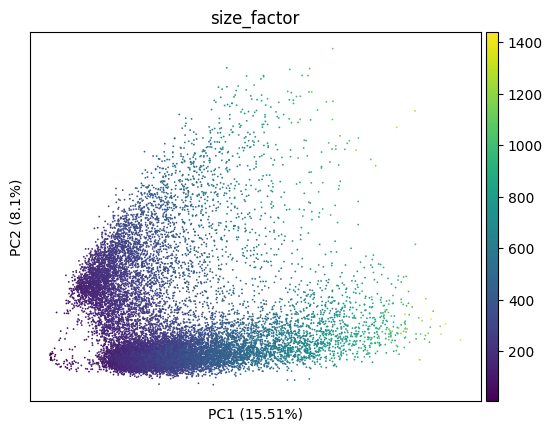

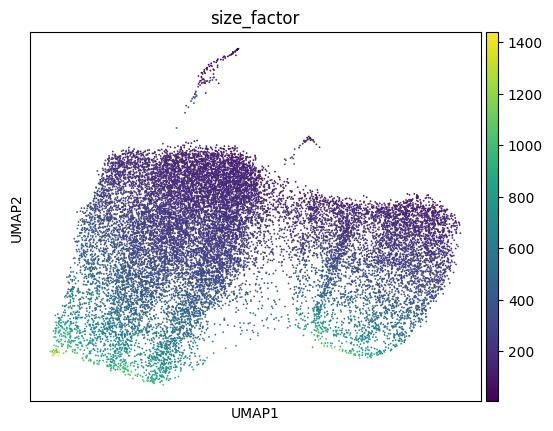

In [17]:
sc.pl.pca(adata_generated, color="size_factor", annotate_var_explained=True)
sc.pl.umap(adata_generated, color="size_factor")

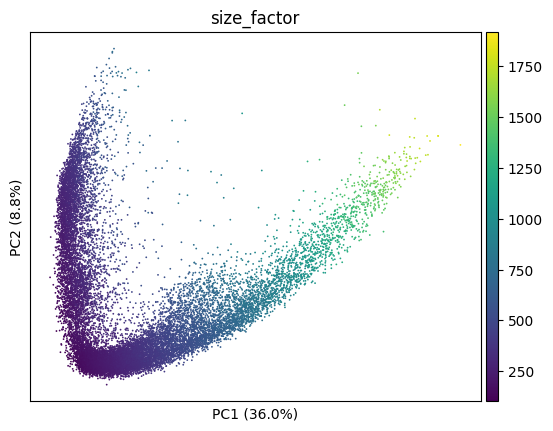

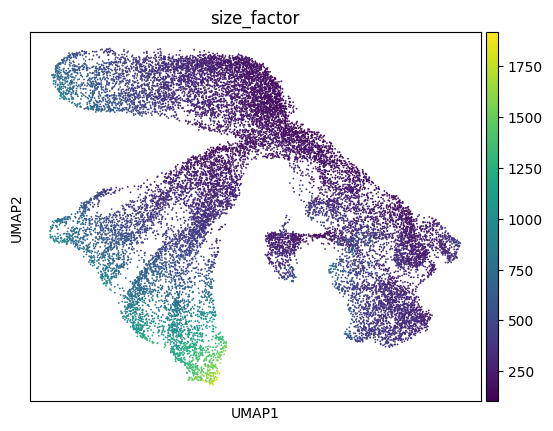

In [18]:
sc.pl.pca(adata_original, color="size_factor",  annotate_var_explained=True)
sc.pl.umap(adata_original, color="size_factor")

Merge and plot the generated and real data

In [19]:
dataset_type = ["Real" for _ in range(X.shape[0])] + ["Generated" for _ in range(X_generated.shape[0])]
dataset_type = pd.DataFrame(dataset_type)
dataset_type.columns = ["dataset_type"]

In [20]:
adata_merged = sc.AnnData(X=torch.cat([X, X_generated], dim=0).numpy(), 
                             obs=dataset_type)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [21]:
sc.pp.log1p(adata_merged) 
sc.tl.pca(adata_merged)
sc.pp.neighbors(adata_merged)
sc.tl.umap(adata_merged)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


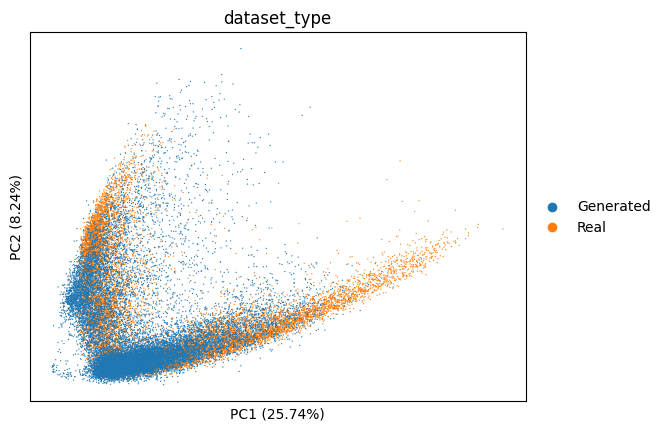

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


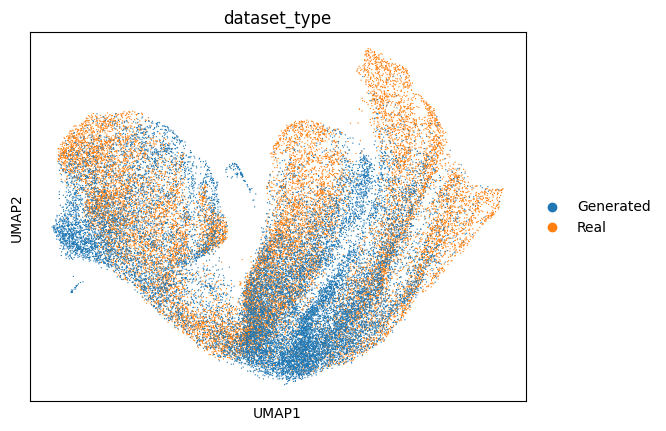

In [22]:
sc.pl.pca(adata_merged, color="dataset_type",  annotate_var_explained=True)
sc.pl.umap(adata_merged, color="dataset_type")

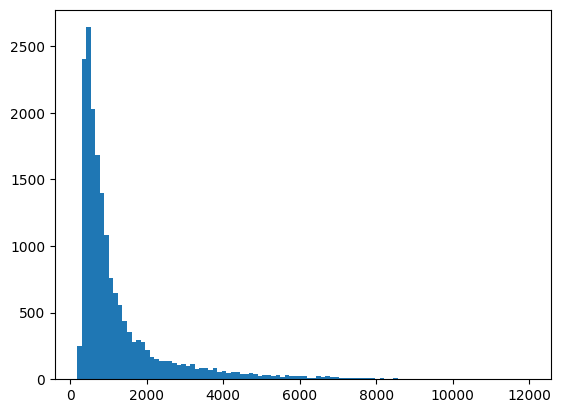

In [23]:
plt.hist(X_generated.sum(1), 100)
plt.show()

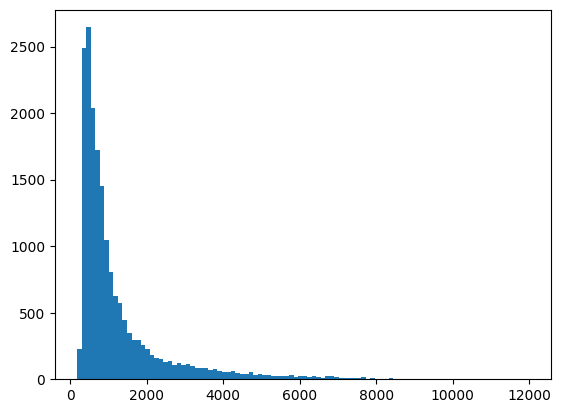

In [24]:
plt.hist(X.sum(1), 100)
plt.show()

In [25]:
(X_generated==0).sum(1).float().mean()

tensor(1755.7268)

In [26]:
(X==0).sum(1).float().mean()

tensor(1649.3105)

In [27]:
X.mean(1).mean()

tensor(0.6263)

In [28]:
X_generated.mean(1).mean()

tensor(0.6268)

**Compute metrics**

In [29]:
# normalize_and_compute_metrics(adata_original, adata_generated, layer="X_pca", sparse=False)

In [30]:
# compute_prdc(adata_original.obsm["X_pca"], adata_generated.obsm["X_pca"], 10)

**Compare zeros**

In [56]:
zeros_generated = (X_generated==0).sum(1).float()
zeros_true = (X==0).sum(1).float()

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/seaborn/_oldcor

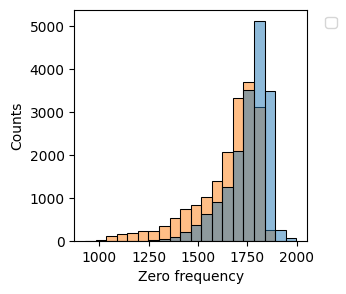

In [87]:
# Combine the two arrays into one numpy array
import seaborn as sns
combined_zeros = np.concatenate((zeros_generated, zeros_true))

plt.figure(figsize=(3,3))
# Create an array indicating the source of each value (0 for generated, 1 for true)
source = ["Generated" for _ in range(len(zeros_generated))] + ["True" for _ in range(len(zeros_true))]
df = pd.DataFrame({"Source": source, "Counts":combined_zeros})
df["Source"] = df["Source"].astype("category")

# Plot histograms using seaborn
sns.histplot(df, x="Counts", hue="Source", bins=20)
plt.xlabel('Zero frequency')
plt.ylabel('Counts')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [88]:
hist_generated, bin_edges = np.histogram(zeros_generated, bins=20, density=True)
hist_true, _ = np.histogram(zeros_true, bins=bin_edges, density=True)

# Compute the minimum values for each bin to find the intersection
intersection = np.minimum(hist_generated, hist_true)

# Calculate the total intersection area
intersection_area = np.sum(intersection * np.diff(bin_edges))

print("Intersection area:", intersection_area)

Intersection area: 0.6891842547942133


**Compare gene expression**

In [108]:
adata_generated_analyis = sc.AnnData(X=sp.csr_matrix(deepcopy(X_generated).cpu().numpy()))

In [100]:
adata_original_analyis = adata_original.copy()
adata_original_analyis.X = adata_original.layers["X_counts"]

In [112]:
adata_generated_analyis.var = adata_original_analyis.var

In [113]:
adata_generated_analyis

AnnData object with n_obs × n_vars = 18000 × 2000
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'